In [21]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from aux_tutorials import *
from src.utils import set_working_directories

data_folder = set_working_directories('circle')[0]



In [22]:

mat = sio.loadmat(data_folder+'circle_data.mat')
data = np.array([mat['ux'], mat['uy']]) 
data[np.isnan(data)] = 0.


In [23]:
Nu, Nt, Nx, Ny = data.shape
grid_shape = (Nu, Nx, Ny)

data = data.transpose(0, 2, 3, 1)  # We want data dimensions as (Nu, Nt, Nx, Ny) 

N_test = int(.6 * Nt)
X_test = data[..., -N_test:].copy()
X_train = data[..., :-N_test].copy()

In [24]:
from modulo_vki.modulo import ModuloVKI as Modulo


def run_snapshot_POD(Q):
    """ 
        Snapshot POD decomposition using MODULO
        X(x, t) = Φ(t) Σ Ψ(x), where X = Q - Q_mean
        returns Φ, Ψ, Σ
        
    """

    Q = Q.reshape((-1, Q.shape[-1]))  
    Q_mean = np.mean(Q, axis=-1, keepdims=True)

    m = Modulo(data=Q - Q_mean, n_Modes=N_modes)  
    
    return m.compute_POD_K() 


In [25]:
N_modes = 10
Psi, Phi, Sigma = run_snapshot_POD(Q=X_train)

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.


In [26]:

def plot_POD_modes(cmap='viridis'):

    POD_basis = np.reshape(Psi, newshape=(*grid_shape, N_modes))

    x1 = np.arange(grid_shape[1])
    x2 = np.arange(grid_shape[2])

    X1, X2 = np.meshgrid(x1, x2, indexing='ij')

    n_col = min(N_modes, 5)
    n_row = int((N_modes + 1) // n_col)

    for jj, data, ttl in zip(range(POD_basis.shape[0]), POD_basis, ['$u_x$', '$u_y$']):
        fig1 = plt.figure(figsize=(3.5 * n_col + 1., 2.5 * n_row), layout='constrained')
        axs = fig1.subplots(nrows=n_row, ncols=n_col, sharex=True, sharey=True)

        for kk, ax in zip(range(N_modes), axs.ravel()):
            im0 = ax.pcolormesh(X1, X2, data[...,kk], rasterized=True)

            if kk >= N_modes - n_col:
                ax.set(xlabel='$y$')
            if kk % n_col == 0:
                ax.set(ylabel='$x$')
            if (kk + 1) % n_col == 0:
                fig1.colorbar(mappable=im0, ax=ax, label=ttl)

            ax.set(title=f'mode {kk+1}')
            


def plot_spectrum(Q, max_mode=None):
    """
    The energy of each POD mode is given by λ_i / 2, where λ_i = sigma_i^2
    """

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    Lambda = Sigma ** 2

    axs[0].bar(np.arange(N_modes), Lambda / Lambda[0], color='C4')
    axs[0].set(xlabel='Mode number $j$', title='$\\lambda_j / \\lambda_0$', xlim=[-1, max(N_modes, 10)])
    axs[1].plot(np.arange(N_modes), np.cumsum(Lambda) / sum(Lambda), color='C4',
                 label='$\\dfrac{\\sum_{j}{\,\\lambda_j}}{ \\sum_{k=0}^{' + f'{N_modes}' + '}\\lambda_k}$')

    # Compute the total kinetic energy of the system to checjh the POD energy reconstruction
    Q -= np.mean(Q, axis=-1, keepdims=True)
    TKE = 0.5 * np.sum((np.mean(Q[0] ** 2, axis=2) + np.mean(Q[1] ** 2, axis=2)))

    POD_energy = Lambda / (2 * Phi.shape[0])
    axs[1].plot(np.arange(N_modes), np.cumsum(POD_energy) / TKE, dashes=[10, 2], color='k', 
                label='$\\dfrac{\\sum_{j}{\,\\lambda_j}}{\mathrm{TKE}}$')
    axs[1].grid(visible=True, linestyle='--', alpha=0.5)
    axs[1].set(xlabel='Mode number $j$', title='Cumulative energy', xlim=[0, max_mode])
    axs[1].legend(ncol=2)
    axs[0].set(ylim=[0, None],  xlim=[-1, max_mode])

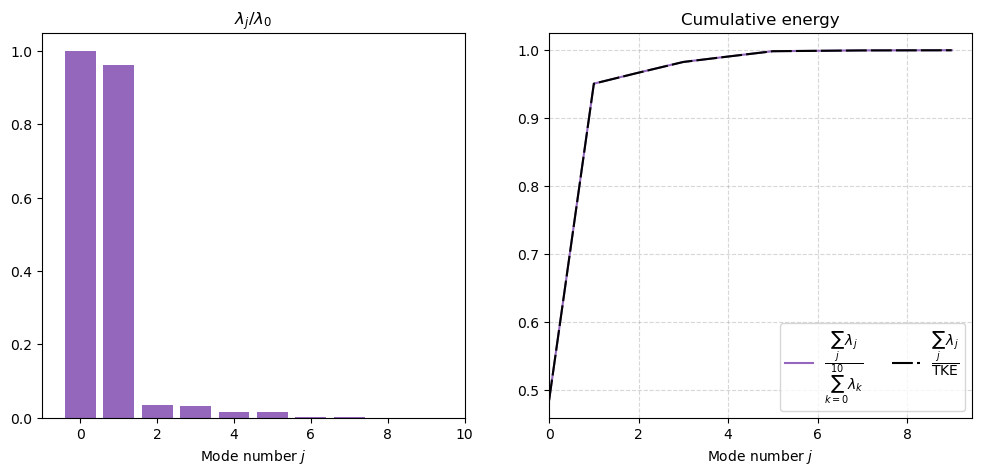

In [27]:
plot_spectrum(Q=X_train)

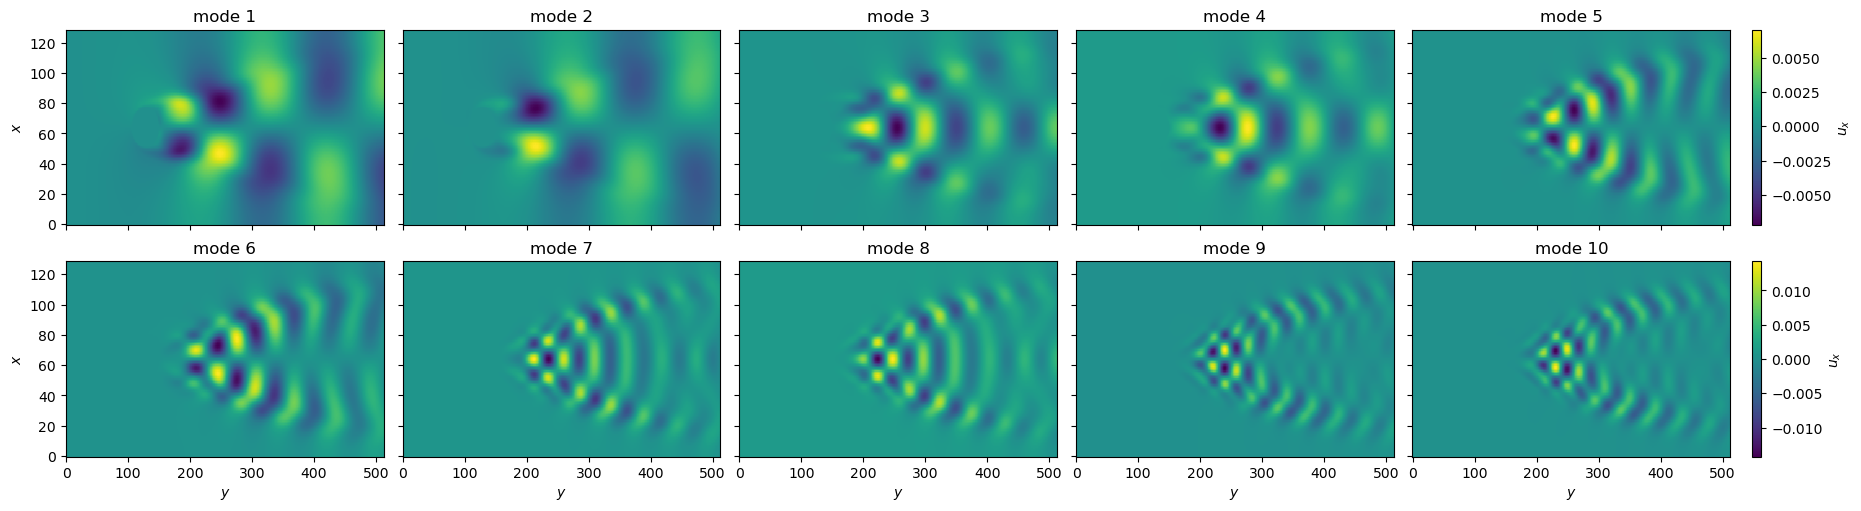

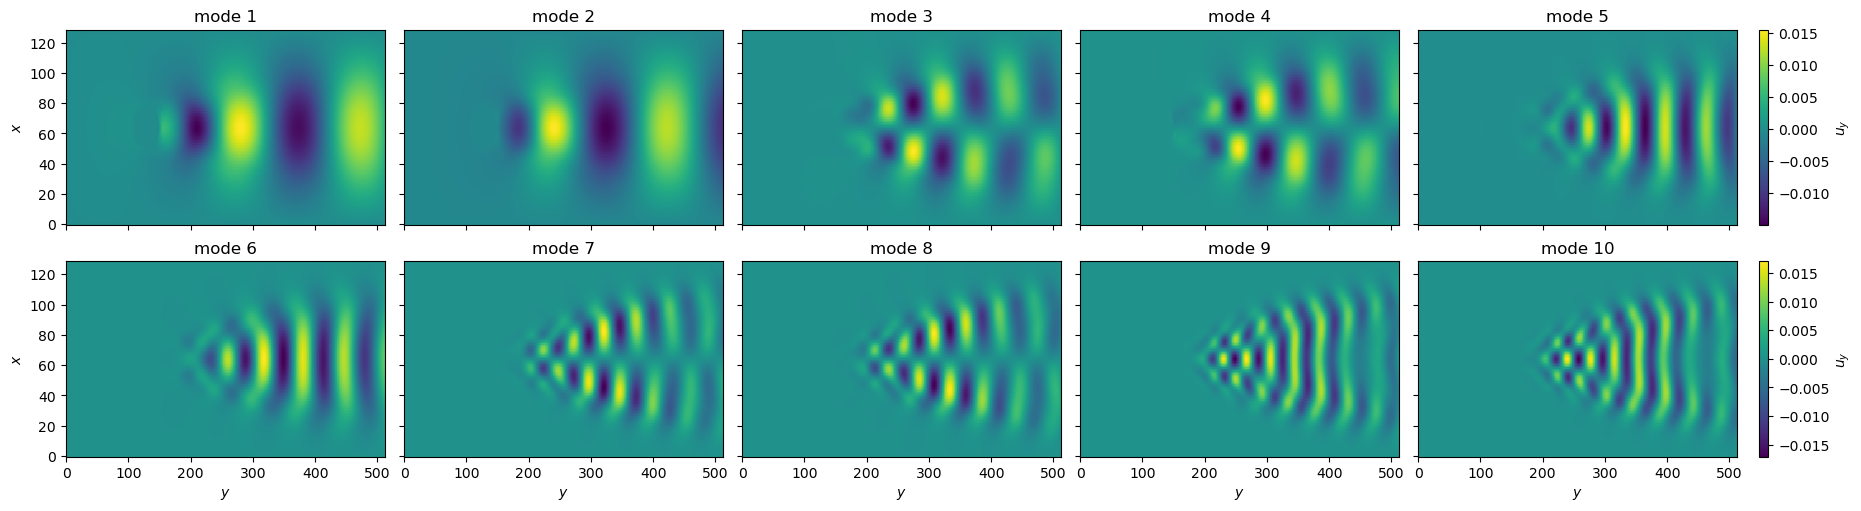

In [28]:
plot_POD_modes()

# We can do the same with the POD class

In [29]:
from src.ML_models.POD import POD

print(X_train.shape)

pod_object = POD(X=X_train.transpose(0, 2, 1, 3), 
                 domain=[-2, 2, 0, 12])
                 

(2, 513, 129, 320)
MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.


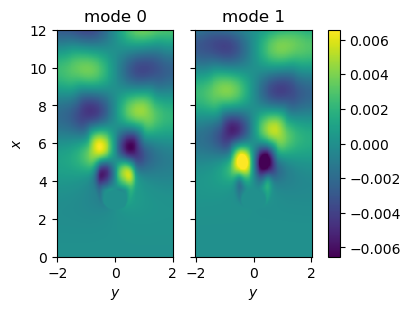

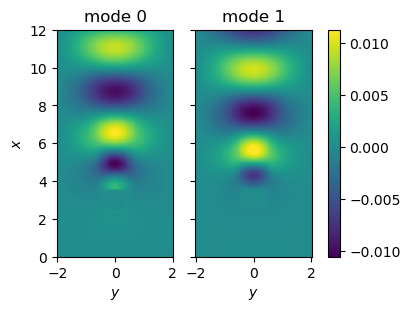

In [30]:
POD.plot_POD_modes(pod_object, cmap='viridis')

In [31]:
help(POD)

Help on class POD in module ML_models.POD:

class POD(builtins.object)
 |  POD(X=None, domain=(-1, 1, -1, 1), plot_decomposition=False, save_decomposition=False, **kwargs)
 |  
 |  Performs POD for a data matrix using MODULO
 |  temporal coefficients.
 |  
 |  D(x,t) = Σ_j σ_j φ_j(x) ψ_j(t)    for  j = 0, ..., N_modes-1
 |  
 |  POD properties:
 |      - Psi: temporal basis [N, N_modes], with N = Ndim x Nx x Ny
 |      - Phi: spatial basis [Nt, N_modes]
 |      - Sigma: POD Sigmas [N_modes, ],  note: Lambdas can be computed as: Sigma = np.sqrt(Lambda)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, X=None, domain=(-1, 1, -1, 1), plot_decomposition=False, save_decomposition=False, **kwargs)
 |      Initialize the POD class.
 |      
 |      Args:
 |          - X (numpy.ndarray, optional): Snapshot data tensor with time as the last dimension.
 |              If X is None, all POD attributes must be provided in kwargs.
 |          - domain (tuple, optional): Domain of the data.
 | 